In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import copy
import adtk
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD, QuantileAD, InterQuartileRangeAD, PersistAD, LevelShiftAD, VolatilityShiftAD
from IPython.display import display
from ydata_profiling import ProfileReport

In [ ]:
data_dir_heater = "../data/smart_home/office_heater.csv"
data_dir_theromostat = "../data/smart_home/office_thermostat.csv"

df_heater = pd.read_csv(
    data_dir_heater,
    delimiter=",",
    header=0,
    parse_dates=True,
)

df_thermostat = pd.read_csv(
    data_dir_theromostat,
    delimiter=",",
    header=0,
    parse_dates=True,
)

# display(df_heater)
# display(df_thermostat)
# df_heater["datetime"] = pd.to_datetime(df_heater["datetime"], format="ISO8601")

,entity_id,state,datetime
0,sensor.buro_temperatur_temperature,19.006897087366667,2024-11-28T23:00:00.000Z
1,sensor.buro_temperatur_temperature,18.73505958303889,2024-11-29T00:00:00.000Z
2,sensor.buro_temperatur_temperature,18.50484492122778,2024-11-29T01:00:00.000Z
3,sensor.buro_temperatur_temperature,18.303428741983335,2024-11-29T02:00:00.000Z
4,sensor.buro_temperatur_temperature,18.09923405276667,2024-11-29T03:00:00.000Z
...,...,...,...
600,sensor.buro_temperatur_temperature,22.67,2024-12-09T11:21:24.168Z
601,sensor.buro_temperatur_temperature,22.47,2024-12-09T11:30:39.872Z
602,sensor.buro_temperatur_temperature,22.13,2024-12-09T11:41:24.139Z
603,sensor.buro_temperatur_temperature,22.67,2024-12-09T12:00:39.821Z


,entity_id,state,datetime,current_temperature,hvac_action,target_temp_high,target_temp_low,temperature
0,climate.eve_thermo_20ebp1701_thermostat_3,heat,2024-11-29T05:16:10.704Z,16.0,NaN,NaN,NaN,17.5
1,climate.eve_thermo_20ebp1701_thermostat_3,heat,2024-11-29T05:23:10.723Z,17.0,NaN,NaN,NaN,17.5
2,climate.eve_thermo_20ebp1701_thermostat_3,heat,2024-11-29T05:30:10.743Z,18.0,NaN,NaN,NaN,17.5
3,climate.eve_thermo_20ebp1701_thermostat_3,heat,2024-11-29T05:39:10.771Z,19.0,NaN,NaN,NaN,17.5
4,climate.eve_thermo_20ebp1701_thermostat_3,heat,2024-11-29T05:49:10.803Z,20.0,NaN,NaN,NaN,17.5
...,...,...,...,...,...,...,...,...
667,climate.eve_thermo_20ebp1701_thermostat_3,off,2024-12-09T11:58:50.013Z,22.0,NaN,NaN,NaN,17.5
668,climate.eve_thermo_20ebp1701_thermostat_3,off,2024-12-09T12:19:55.880Z,21.0,NaN,NaN,NaN,17.5
669,climate.eve_thermo_20ebp1701_thermostat_3,heat,2024-12-09T12:25:36.901Z,21.0,NaN,NaN,NaN,17.5
670,climate.eve_thermo_20ebp1701_thermostat_3,heat,2024-12-09T12:33:48.097Z,21.0,NaN,NaN,NaN,21.5


##### Daten säubern

In [11]:
unique_heater_sensor_state = df_heater["state"].unique()
unique_thermostat_sensor_state = df_thermostat["state"].unique()

# print(unique_heater_sensor_state)
# print(unique_thermostat_sensor_state)

unwanted_heater_sensor_state = ["unavailable", "unknown"]
unwanted_thermostat_sensor_state = ["unavailable"]

df_heater_temp = df_heater
df_thermostat_temp = df_thermostat

df_heater_temp = df_heater_temp[~df_heater_temp["state"].isin(unwanted_heater_sensor_state)]
df_thermostat_temp = df_thermostat_temp[~df_thermostat_temp["state"].isin(unwanted_thermostat_sensor_state)]

# Sortiere die Daten nach Datum und Uhrzeit
df_heater_temp = df_heater_temp.sort_values(by="datetime")
df_thermostat_temp = df_thermostat_temp.sort_values(by="datetime")

df_heater_temp.to_csv("../data/smart_home/office_heater_clean.csv", index=False)
df_thermostat_temp.to_csv("../data/smart_home/office_thermostat_clean.csv", index=False)

#### Nutze gesäuberten Datensatz

In [ ]:
# Workaround: Datensatz mit Benennung vertauschen. Heizung mit Temperature Sensor wurde bei dem Code vertauscht und ist erst
# später aufgefallen. Keine Lust alle Variablen umzubenennen.
data_dir_heater = "../data/smart_home/office_thermostat_clean.csv"
data_dir_theromostat = "../data/smart_home/office_heater_clean.csv"

df_heater = pd.read_csv(
    data_dir_heater,
    delimiter=",",
    header=0,
    parse_dates=True,
)

df_thermostat = pd.read_csv(
    data_dir_theromostat,
    delimiter=",",
    header=0,
    parse_dates=True,
)

df_heater["datetime"] = pd.to_datetime(df_heater["datetime"], format="ISO8601", errors="coerce")
df_thermostat["datetime"] = pd.to_datetime(df_thermostat["datetime"], format="ISO8601", errors="coerce")

print(df_heater.info())
# df_heater.dtypes

print(df_thermostat.info())
# df_thermostat.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   entity_id            664 non-null    object             
 1   state                664 non-null    object             
 2   datetime             664 non-null    datetime64[ns, UTC]
 3   current_temperature  664 non-null    float64            
 4   hvac_action          0 non-null      float64            
 5   target_temp_high     0 non-null      float64            
 6   target_temp_low      0 non-null      float64            
 7   temperature          664 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(5), object(2)
memory usage: 41.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  ----- 

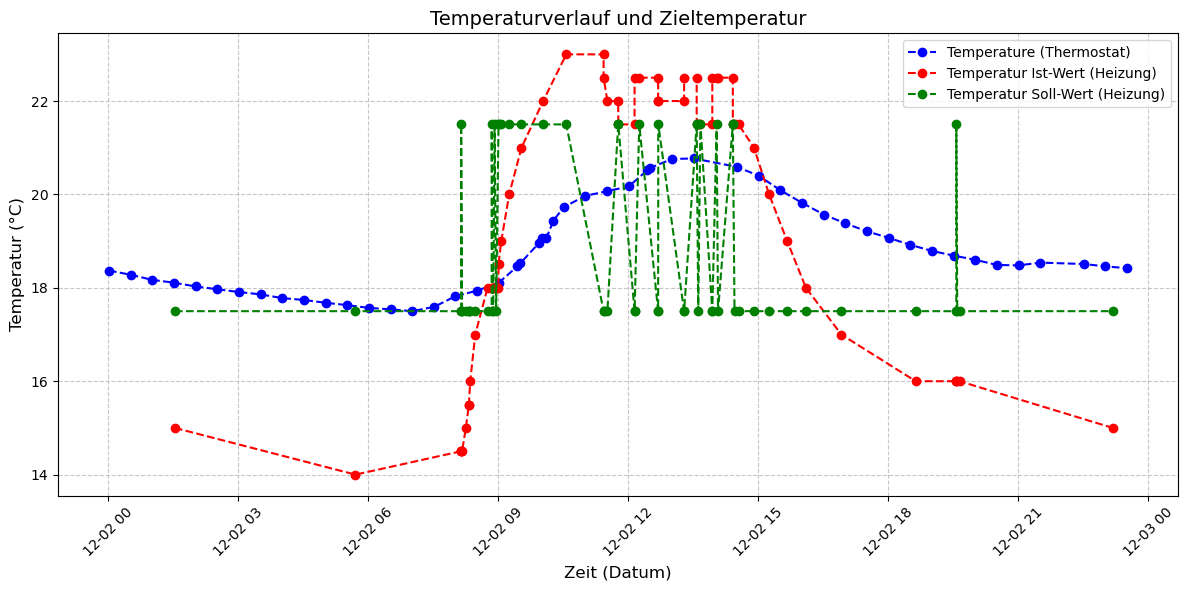

In [ ]:
# Define the date and time ranges
start_time = "2024-12-02 00:00:00"
end_time = "2024-12-02 23:59:59"

# Filtern der Daten nach dem angegebenen Zeitraum
df_heater_filtered = df_heater.copy()
df_thermostat_filtered = df_thermostat.copy()

# Filter anwenden
df_heater_filtered = df_heater_filtered[
    (df_heater_filtered["datetime"] >= start_time) & (df_heater_filtered["datetime"] <= end_time)
]

df_thermostat_filtered = df_thermostat_filtered[
    (df_thermostat_filtered["datetime"] >= start_time) & (df_thermostat_filtered["datetime"] <= end_time)
]

# Plot erstellen
plt.figure(figsize=(12, 6))

# Temperatur-Daten (Thermostat) plotten
plt.plot(
    df_thermostat_filtered["datetime"],
    df_thermostat_filtered["state"],
    marker="o",
    linestyle="--",
    color="blue",
    label="Temperatur (Thermostat)",
)

# Temperatur-Daten (Heizung) plotten
plt.plot(
    df_heater_filtered["datetime"],
    df_heater_filtered["current_temperature"],
    marker="o",
    linestyle="--",
    color="red",
    label="Temperatur Ist-Wert (Heizung)",
)

# Temperatur-Daten (Heizung) plotten
plt.plot(
    df_heater_filtered["datetime"],
    df_heater_filtered["temperature"],
    marker="o",
    linestyle="--",
    color="green",
    label="Temperatur Soll-Wert (Heizung)",
)

# Achsentitel und Diagrammtitel hinzufügen
plt.xlabel("Zeit (Datum)", fontsize=12)
plt.ylabel("Temperatur (°C)", fontsize=12)
plt.title(f"Temperaturverlauf und Zieltemperatur", fontsize=14)  # für den {start_time.split(' ')[0]}

# Extract unique time points for x-axis
# time_points = df_thermostat_filtered["datetime"].apply(lambda t: t.strftime("%H:%M:%S.") + t.strftime("%f")[:2]).tolist()

# Achsenformat anpassen
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()

# Diagramm anzeigen
plt.tight_layout()
plt.show()